In [9]:
import numpy    as     np
import matplotlib.pyplot as plt
from   scipy import integrate
from dataclasses import dataclass,astuple,asdict # for C-like structure

# Stick slip cycles

You have explored Amonton's friction law which says that the shear stress needed to start moving two frictional surface against each other, $\tau_s$, is given by $\tau_ = \mu_s \sigma_n$ where $\mu_s$ is the _static_ friction coefficient, and $\sigma_n$ the normal stress. Friction can be quite complicated, but the first step to move beyond Amonton is to allow for a sliding friction when the surface is moving, the _dynamic_ friction $\mu_d$, such that $\tau_s = \mu_s \sigma_n$.

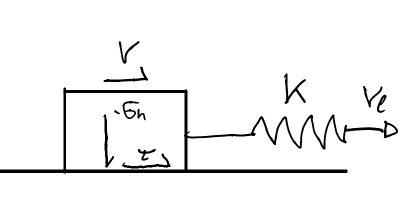

Let's assume that there is a constant loading velocity, $v_0$, extending a spring coupled to a frictional slider. If $x$ is the location of the slider, and $x_l$ the location of the load, and if $x_l=0$ at $t=0$, then $x_l = t v_l$. Hooke's law says that the pull force stored in the spring is 

$F_s=-k \delta x = -k (x-x_l) = -k (x-t v_l).$ 

This is a load on the mass of the slider such that we get an eqation like 

$F_i + F_f(\dot{x}) = F_s$ 

where $F_i$ is inertia, $F_i = m \ddot{x}$, as for the harmonic oscillator, and $F_f(\dot{x})$ a velocity-dependent friction, which is like the damping term of the harmonic oscillator from before. If $\mu(\dot{x})$, then $F_f =  \mathrm{sgn}(\dot{x}) \sigma_n  \mu$, with normal force $\sigma_n$, where $\mathrm{sgn}$ is the sign function, which is 1 or -1, depending on its argument being $>0$ or $<0$, to account for the direction of the pull. 

Let us first define a velocity dependent friction function, and, say, have a linear drop in frction to hopefully make things better behaved. 

In [24]:
@dataclass
class parameters:
    m    :float = 1 # mass
    k    :float = .1 # spring stiffness
    mu_s :float = 0.6
    mu_d :float = 0.1
    sn   :float = 1
    v0   :float = 1
    vmax :float = .1

def friction(vel,mu_d,mu_s,vmax): 
    vela = np.abs(vel)
    indpl = np.where(vela>vmax)
    indps = np.where((vela>0) & (vela <=vmax))

    fric = np.ones(vela.size) * mu_s
    for i in indpl:
        fric[i] = fric[i] - (mu_s-mu_d)
    for i in indps:
        fac = vela[i]/vmax
        fric[i] = fric[i] - fac**0.5  * (mu_s - mu_d)
    return fric 

Everytime we have a new function, let's make sure it works, by plotting it. 

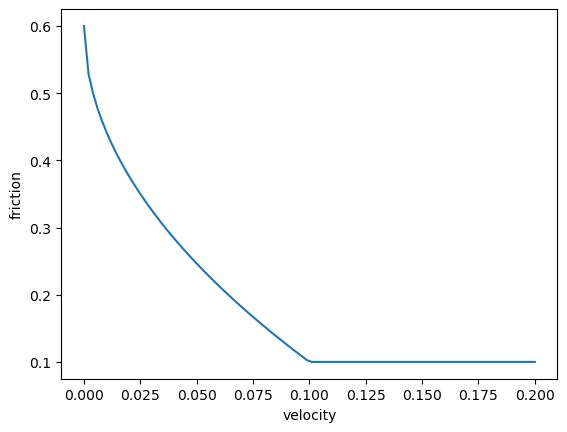

In [25]:
par        = parameters()      

vel = np.linspace(0,par.vmax*2,100)
fric = friction(vel,par.mu_d,par.mu_s,par.vmax)                  
plt.plot(vel,fric);plt.xlabel('velocity');plt.ylabel('friction')
plt.show()

Does it look OK? Later, see what happens if you change $\mu_d$, $\mu_s$, and $v_{max}$, for example. 

Now, for the ODEs to solve the slider problem where this friction applies, let's be inspired by the harmonic oscillator from last time. 

\begin{align}
m \ddot{x} +   \mathrm{sgn}(\dot{x}) \sigma_n \mu(\dot{x}) = -k(x-t v_l)
\end{align}
such that inertia is balanced by the frictional force, and driven by the continuously extending spring, driven by $v_l$. 
Again, introduce $\dot{x} = y$ to only have first order derivatives with time. Then, 

\begin{align}
m \dot{y} +  \mathrm{sgn}(\dot{x})  \sigma_n  \mu(y) = -k(x-tv_l)\\
\dot{y} = -\frac{k(x-tv_0)+ \mathrm{sgn}(\dot{x})  \sigma_n  \mu(y)}{m}\\
\end{align}

Which we can write as computer code for the ODE solver from before, using our friction function, as:

In [26]:
def dxdt(x, t, m,k,mu_d,mu_s,smA,v0,vmax): 
    f0 = x[1]
    f1 = -(k*(x[0]-t*v0) + np.sign(x[1])*par.sn*friction([x[1]],mu_d,mu_s,vmax))/m 
    return [f0,f1]

def ode_solver_scipy(xInit,t, par):
    sol     = integrate.odeint(dxdt, xInit, t, astuple(par), rtol=1e-12)
    return sol

Let's see what this system does. Try a few combinations of $v_0$ and $k$, say vary both between 1 and 100, e.g. 1, 5, 10, 50, 100. Does this look like what you got in the experiments? 

Fill in the blanks to make plots. Plot the key parameters against time. Besides those plots, how else might you analyze what is going on?

What different system behaviors can you distinguish? What do they mean physically? 

(4000, 2)


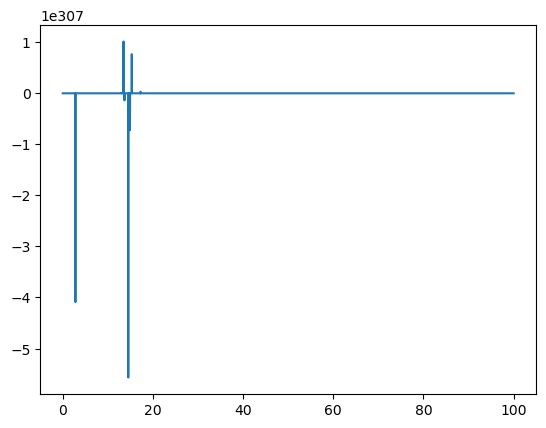

In [34]:
x0=[0,0.5]
tmax=100
nsteps = 4000
t = np.linspace(0,tmax,nsteps)
par.m=.5;par.k=.1;par.v0=1
x   = ode_solver_scipy(x0,t,par)
print(np.shape(x))
force=par.k*(x[:,0]-t*par.v0)

plt.plot(t,x[:,0]);
plt.show()


## Rate-state friction with inertia

Now, let us consider a more complicated dependence of friction, what is called __rate-state friction__ (RSF) behavior. In general, experiments find a sliding velocity and time dependence, like so 

$\mu = \mu_0 + a \ln\left(\frac{v}{v_0}\right) + b \ln\left(\frac{\theta}{D_c/v_0}\right)$, 

where $a$ and $b$ are parameters, $D_c$ and $v_0$ reference length and velocity scales, respectively, and $\theta$ a _state variable_ which allows for effects other than velocity dependent friction, in particular _healing_, that is an increase of static friction with _hold time_.  We then need to pair the friction equation with an _evolution law_ that captures the state variable evolution, such as 

$\dot{\theta} = 1-\frac{v\theta}{D_c},$

which is called the _ageing law_. This means that in steady-state, when $\dot{\theta}=0$, $\theta_{ss} = \frac{D_c}{v}$. Also, for this law, if there is no sliding, $v=0$, then $\dot{\theta} = 1$, a linear increase of the state variable with time. 

For the numerical implementation, we use a different version of the RSF law that is _regularized_ (the logs can cause problems), and better behaved,

$\mu = a \sinh^{-1}\left(\frac{v}{2v_0} \exp\left(\frac{\mu_0 + b \ln\left(v_0 \theta/L\right)}{a}\right)\right).$

In [38]:
def rs_friction(mu0,vel,v0,a,b,Dc,theta): 
    #fric = mu0+a*np.log(vel/v0) + b *np.log(theta/(Dc/v0))
    fric= a*np.arcsinh(vel/(2*v0)*np.exp((mu0+b*np.log(v0*theta/Dc))/a))
    return fric 

@dataclass
class rs_parameters:
    m    :float = 1 # mass
    k    :float = 1 # spring stiffness
    mu_0 :float = 0.6
    a    :float = 0.01
    b    :float = 0.03
    Dc   :float = 5
    v0   :float = 1
    sn   :float = 1

Let's test what this friction law predicts for steady-state, where $\theta$ does not change. 

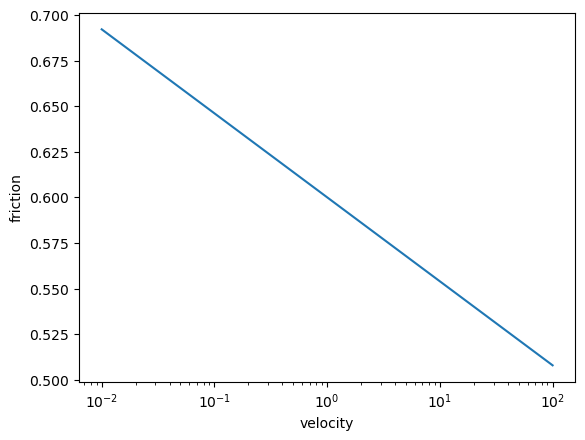

In [37]:
par = rs_parameters()
nstep = 100
vel = np.linspace(par.v0/100,par.v0*100,nstep)
fric = rs_friction(par.mu_0,vel,par.v0,par.a,par.b,par.Dc,par.Dc/vel)
plt.semilogx(vel,fric);plt.xlabel('velocity');plt.ylabel('friction')
plt.show()

Which parameters controls the velocity dependence of friction?

Let's see what happens for zero sliding velocity for which $\theta$ increases linearly.

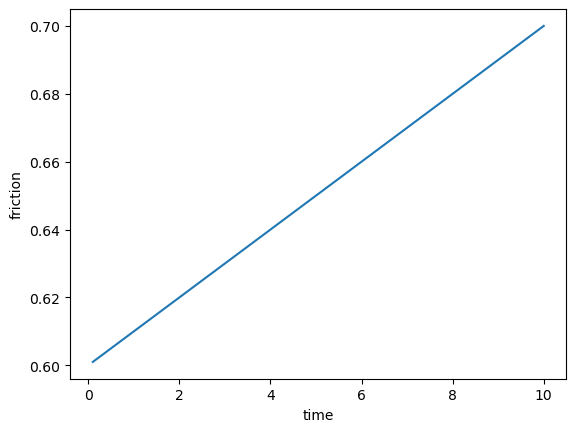

In [39]:
vel = np.zeros(nstep)
time = np.linspace(0.1,10,nsteps)
theta = .6+time*0.01
fric = rs_friction(par.mu_0,0,par.v0,par.a,par.b,par.Dc,theta)
plt.plot(time,theta);plt.xlabel('time');plt.ylabel('friction')
plt.show()

Let's set up the equations for a spring-slider system with the RSF formulation for ${\bf x} = \{x,y,\theta,x_{load}\}$, with $y=\dot{x}$, 

\begin{align}
\dot{x} &= y\\
\dot{y} &= -\frac{k(x-x_{load})+\mathrm{sgn}(y)\sigma_n\mu(y,\theta))}{m}\\
\dot{\theta} &= 1 - \frac{y\theta}{D_c}\\
\dot{x}_{load} &= v_0\\
\end{align}


In [72]:
def dxdt(x, t, m,k,mu_0,a,b,Dc,v0,sn): 
    vel = np.asarray(x[1])
    state = np.asarray(x[2])
    load_loc = np.asarray(x[3])
    # this is where we make the loading a bit more interesting
    if(t>10):
        vload = v0*10
    elif(t>3):
        vload = v0*10
    else:
        vload = v0
    f0 = x[1] # velocity 
    f1 = -(k*(x[0]-load_loc) +np.sign(vel)*par.sn*rs_friction(mu_0,vel,v0,a,b,Dc,state))/m 
    f2 = 1-vel*state/Dc # evolution law
    f3 = vload
    return [f0,f1,f2,f3]

Let's see what that looks like. Plot displacement against time, friction against time, and visualize the overall system behavior. 

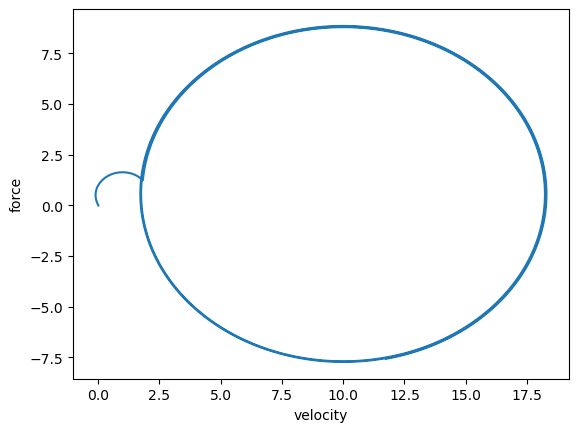

In [74]:
par        = rs_parameters()
x0=[0.01,0.01,0.01,0]
tmax=20
nsteps = 4000
t = np.linspace(0,tmax,nsteps)
par.k=1;par.m=1;par.sn=1;par.v0=1;
x   = ode_solver_scipy(x0,t,par)

displacement=x[:,0];velocity=x[:,1];state=x[:,2];loadpoint_displacement=x[:,3]

force = par.k*(loadpoint_displacement-displacement) # loading force
fric = rs_friction(par.mu_0,velocity,par.v0,par.a,par.b,par.Dc,state)
plt.plot(velocity,force);plt.xlabel('velocity');plt.ylabel('force');plt.show()

Describe and analyze what is happening. 

## Rate-state friction without inertia but possibly more than one state variable

The rate- and state friction is described by the following governing equations are in general something like

\begin{align}
\tau = F[V, \theta_1, \theta_2, ... ] \\
\dot \theta_1 = G_1[V, \theta_1, \theta_2, ...] \\ 
\dot \theta_2 = G_2[V, \theta_1, \theta_2, ...] \\ 
...
\end{align}
where we might allow for more than one state variable, $\theta_1$, $\theta_2$, $\ldots$, with 

$\mu = \mu_0 + a \ln\left(\frac{v}{v_0}\right) + b_1 \ln\left(\frac{\theta_1}{\theta_0}\right) + b_2 \ln\left(\frac{\theta_2}{\theta_0}\right)$, 

with $\theta_0 = \frac{D_c}{v_0}$, and we will now use a different, the Ruina, _slip law_ version of the state variable evolution laws

$
\dot{\theta}_i = -\frac{v}{D_c} \left(\theta_i + b_i \log\frac{v}{v_0}\right).
$


The simpliest form of interaction between the rate and state friction and elastic deformation is described by the one degree spring-slider system governed by the rate and state friction where we now do only consider quasi-dynamic sliding, not using the mass/inertia. 

Following Gu et al. (1984), we can rewrite the equations and solve for  a logarithmic sliding velocity

$
x = \ln\left(\frac{v}{v_0}\right),
$

and a normalized friction difference from the reference, or shear stress, since $\tau = \mu \sigma_n$ and we hold $\sigma_n$ constant,


$
y = \frac{\tau - \tau_0}{a},
$

with $\Theta=\frac{\theta}{a}$ a non-dimensional state variable 

$
\Theta_i =\beta_i \log\left(\frac{\theta_i}{\theta_0}\right),
$

where $\beta = \frac{b}{a}$.

With a non-dimensional stiffness, $\kappa = \frac{k D_c}{a\sigma_n}$, the governing equations for the evolution of ${\bf x}=\{x,y,v'_l\}$ can be written as 

\begin{align}
\frac{d x}{dT} &= e^x (-\kappa + y + \lambda x) + \kappa v'_l  \\
\frac{d y}{dT} &= \kappa (v'_l - e^x) \\
\frac{d v_l}{dT} &= v'_l\\
\end{align}

where $T=\frac{t}{\theta_0}$ is a non-dimensionalized time, $v_l'=v_l/v_0$, $\lambda = \beta-1$, and a critical stiffness can be derived as

$
\kappa_c = \lambda = \beta-1 = \frac{b-a}{a},
$

and the system could be further condensed into a 2-D description, but we carry three variables explcitly for simplicity.


In [13]:
# Solve an elastic spring-slider system governed by the rate and state friction.
# A numerical implementation of Gu et al. (1984).
@dataclass
class rs2_parameters:
    kappa:float = 1 # non-dim stiffness, normalized to kappa_c, i.e. in multiples of lambda 
    mu_0 :float = 0.6
    a    :float = 0.01
    b    :float = 0.015
    Dc   :float = 1
    mode :int   = 1
        
def dxdt(x, t, kappa,mu_0,a,b,Dc,mode): # x,y,z = x,y,v'_l; x = log(v/v_0); y = (t-t_0)/a

    llambda  = b/a -1
    k   = kappa * llambda 
    v0      = loadHist(t, mode)
    exp_x = np.exp(x[0])
    
    f0 = exp_x*(-k + x[1] + llambda*x[0]) + k*v0
    f1 = k * (v0 - exp_x)
    f2 = v0
    
    return [f0,f1,f2]

# loadHist defines the loading (velocity) profiles for the whole time series.
# various experiments are defined by the parameter mode. 
def loadHist(t, mode):
    v           = 0
    if mode   == 1:
        if t   < 0: 
            v   = 1
        elif t < 5:
            v   = 3
        else:
            v   = 1
    elif mode == 2:
        v       = 1
    return v


Now, let's see what this does for different values of $\kappa_c$. Change $\kappa$ from 50, 5, 1 $\kappa_c$, for example. Plot friction vs. time. Plot the phase space behaviro for different $\kappa$.

In [14]:
par       = rs2_parameters()
Nt        = 100000
t         = np.linspace(-5., 50., Nt)
par.kappa = 50
x0     = [0, .1, 0.]
x1   = ode_solver_scipy(x0,t,par)
par.kappa = 1
x2   = ode_solver_scipy(x0,t,par)

fric1=par.mu_0 + x1[:,1]*par.a
fric2=par.mu_0 + x2[:,1]*par.a


What is happening? Can you analyze the phase space behavior? What might the system do, i.e. what are possible curves?